In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as mp
import seaborn as sb

from pathlib import Path
from IPython.display import display
from prophet import Prophet
from scipy.stats import f_oneway

db = sqlite3.connect('../data/movies_project.db')

movies_df = pd.read_sql_query("SELECT * FROM movies", db)
starring_df = pd.read_sql_query("SELECT * FROM starring", db)
genres_df = pd.read_sql_query("SELECT * FROM genres", db)
directors_df = pd.read_sql_query("SELECT * FROM directors", db)
platforms_df = pd.read_sql_query("SELECT * FROM platforms", db)

filtered_movies = movies_df.loc[(movies_df['revenue']>0)&(movies_df['budget']>= 900000)]


#### Phase 6 — Intended Audience Trends
Question: *Do audience age targets affect runtime, ratings, or revenue performance across platforms?*

Hypothesis: Younger audiences have shorter films (assumption from short attention span).

In [2]:
query = """
SELECT p.age, ROUND(AVG(m.minutes),2) avg_runtime
FROM movies m
JOIN platforms p on p.title = m.title
GROUP BY p.age
ORDER BY avg(m.minutes) DESC;
"""

q11 = pd.read_sql_query(query,db)
display(q11)

,age,avg_runtime
0,all,67.22
1,13+,64.52
2,16+,64.37
3,7+,63.88
4,Unknown,60.45
5,18+,59.93


#### Finding: 
Runtime does not vary significantly by age group, suggesting studios do not tailor film length by intended audience.

#### Highest-Rated Audience Group per Platform

In [3]:
query = """
WITH avgs AS (
    SELECT 
        p.platform,
        p.age,
        ROUND(AVG(m.ratings),1) AS avg_rating, 
        AVG(m.count)  AS avg_count
    FROM movies m
    JOIN platforms p ON p.title = m.title
    WHERE m.ratings > 0
      AND m.count  >= 665
      AND m.budget > 900000
      AND m.revenue >= 560471.5
      AND p.age != 'Unknown'
    GROUP BY p.platform, p.age
)
SELECT platform, age, avg_rating
FROM (
    SELECT platform, age, avg_rating, avg_count,
           ROW_NUMBER() OVER (
               PARTITION BY platform 
               ORDER BY avg_rating DESC, avg_count DESC
           ) AS rn
    FROM avgs
) ranked
WHERE rn = 1;

"""


q12 = pd.read_sql_query(query,db)
display(q12)

,platform,age,avg_rating
0,Disney+,13+,7.0
1,Hulu,all,7.1
2,Netflix,18+,6.7
3,Prime Video,all,6.7


#### Finding: 
- Disney+ stands out—its highest-rated titles target 13+, suggesting that teen-focused content drives critical success.

- Hulu and Prime Video both perform best with content labeled All, reflecting a strong preference for broad, family-friendly programming.

- Netflix skews slightly older, with its top ratings coming from 18+ audiences.

Platform strategies differ, but ratings leadership is not strictly tied to younger or older audiences.

#### Top-3 Age Groups per Platform (Ratings & ROI)


In [4]:
query = """
SELECT platform, age, avg_ratings, CONCAT(roi,'%') AS roi
FROM (
    SELECT p.platform, p.age,
           ROUND(AVG(m.ratings),1) AS avg_ratings,
           ROW_NUMBER() OVER (
               PARTITION BY p.platform 
               ORDER BY AVG(m.ratings) DESC
           ) AS rn,
           ROUND(AVG(m.roi),1) AS roi
    FROM movies m
    JOIN platforms p ON p.title = m.title
    WHERE m.ratings > 0
      AND m.count >= 665
      AND m.budget > 900000
      AND m.revenue >= 560471.5
      AND p.age != 'Unknown'
    GROUP BY p.platform, p.age
) ranked
WHERE rn <= 3
ORDER BY platform, avg_ratings DESC;

"""
q13 = pd.read_sql_query(query,db)
display(q13)

,platform,age,avg_ratings,roi
0,Disney+,13+,7.0,436.0%
1,Disney+,all,6.8,752.1%
2,Disney+,7+,6.5,263.9%
3,Hulu,all,7.1,256.4%
4,Hulu,16+,6.9,278.1%
5,Hulu,18+,6.6,228.9%
6,Netflix,18+,6.7,204.0%
7,Netflix,13+,6.6,284.3%
8,Netflix,all,6.5,190.1%
9,Prime Video,all,6.7,767.8%


#### Finding: 
- Disney+: Dominated by younger audiences (7+, All, 13+), roughly spanning G to PG-13.

- Hulu: Leans teen/young adult (All first, then 16+, 18+).

- Netflix: More diverse (18+, 13+, All), ranging from PG-13 to R.

- Prime Video: Broadest spread (All, 7+, 18+), rated highly in everything from family content to mature titles.

**Takeaway:** Ratings aren't perfectly aligned with profitability.
Prime Video achieves both high ratings and the highest ROI (~768%) across majority age groups.

#### Platform Breadth
*Which platforms have the widest spread of age categories?*

In [5]:
query = """
SELECT 
    p.platform, 
    p.age, 
    count(*) as `count of titles`,
    ROUND(AVG(revenue),0) AS avg_revenue
FROM platforms p
JOIN movies m on m.title = p.title
WHERE 
    age != 'Unknown' AND
    revenue > 0
GROUP BY platform, age
ORDER BY platform DESC, count(*) DESC;

"""
q14 = pd.read_sql_query(query,db)
display(q14)

,platform,age,count of titles,avg_revenue
0,Prime Video,18+,502,19385252.0
1,Prime Video,13+,225,44896359.0
2,Prime Video,7+,158,31372566.0
3,Prime Video,all,52,53204730.0
4,Prime Video,16+,15,30991304.0
5,Netflix,18+,343,38124900.0
6,Netflix,13+,258,79705052.0
7,Netflix,7+,134,103590307.0
8,Netflix,16+,34,41187153.0
9,Netflix,all,29,28148021.0


#### ROI vs Ratings by Age Group
*Within each platform, do higher-rated age categories also earn higher ROI?*

In [7]:
# Merge and filter the data
merged = (
    movies_df[
        (movies_df['ratings'] > 0) &
        (movies_df['count'] >= 665) &
        (movies_df['budget'] >= 900000) &
        (movies_df['revenue'] >= 560471.5)
    ]
    .merge(
        platforms_df[platforms_df['age'] != 'Unknown'],
        on='title',
        how='inner'
    )
    .groupby(['platform', 'age','id'], as_index=False)
    .agg(
        avg_rating=('ratings', 'mean'),
        avg_roi=('ROI', 'mean')
    )
)

# Pearson correlation
pearson_corr = merged['avg_rating'].corr(merged['avg_roi'], method='pearson')
print("Pearson correlation:", pearson_corr)

# Spearman correlation
spearman_corr = merged['avg_rating'].corr(merged['avg_roi'], method='spearman')
print("Spearman correlation:", spearman_corr)


Pearson correlation: 0.21310413901582576
Spearman correlation: 0.3491209198377016


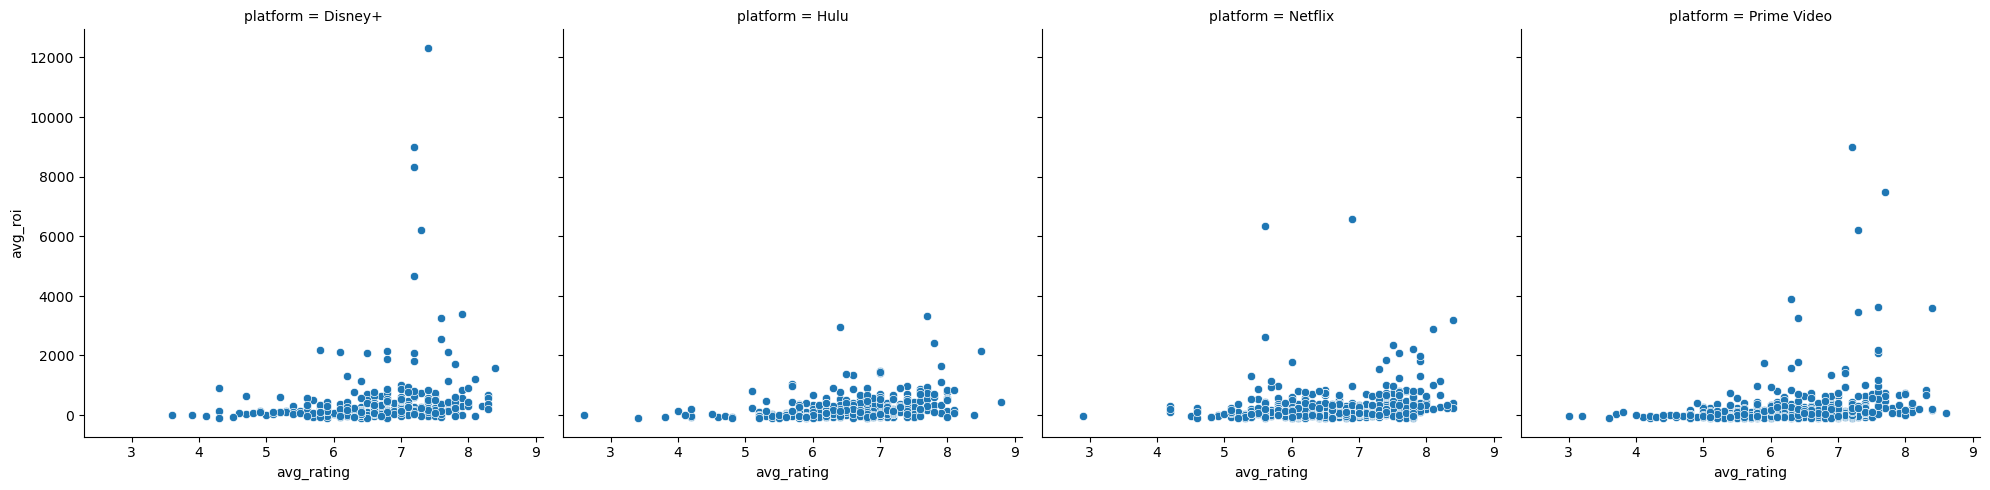

In [8]:
sb.relplot(data=merged, x='avg_rating', y='avg_roi',col='platform',kind='scatter')
mp.show()

There is only a weak positive relationship between ratings and ROI, meaning critically acclaimed films do not necessarily guarantee profitability.


#### Genre × Age x Platform Combinations 
Since we found ratings to not necessarily drive roi, we will take a step back and focus on what are most successfuBudgets are systematically higher for family/fantasy/animation content, but the most efficient ROI often comes from low-budget documentaries and horror. This confirms that budget size does not predict ROI — instead, studios pursue two distinct ROI strategies: large-scale blockbusters vs lean, high-efficiency productions.”l in terms of pofitability on bare minimum of budget being greter than
For each platform, which of the age-genre delivers the highest ROI?

In [9]:
query = """

SELECT
    platform,
    age,
    genre,
    CONCAT(avg_roi,'%') AS ROI
FROM (
    SELECT 
        p.platform,
        g.genre,
        p.age,
        ROUND(AVG(m.roi),0) AS avg_roi,
        ROW_NUMBER() OVER (
            PARTITION BY p.platform
            ORDER BY AVG(m.roi) DESC
        ) AS rn
    FROM movies m
    JOIN genres g ON g.movie_id = m.id
    JOIN platforms p ON p.title = m.title
    WHERE 
        p.age != 'Unknown' AND
        m.budget >= 900000 AND
        m.revenue >= 560471.5
    GROUP BY p.platform, g.genre, p.age
) ranked
WHERE rn <= 3
ORDER BY platform, avg_roi DESC;


"""
q15 = pd.read_sql_query(query,db)
display(q15)

,platform,age,genre,ROI
0,Disney+,13+,Animation,1687.0%
1,Disney+,all,Fantasy,1259.0%
2,Disney+,13+,Romance,1183.0%
3,Hulu,13+,Documentary,1477.0%
4,Hulu,16+,Horror,930.0%
5,Hulu,all,Crime,829.0%
6,Netflix,13+,Music,5662.0%
7,Netflix,7+,Documentary,1774.0%
8,Netflix,16+,Horror,1660.0%
9,Prime Video,all,Fantasy,2383.0%


#### Budget vs Age x genre x platform
Average budget analysis by age-genre group to confirm if studios spend differently for family vs mature content.

In [10]:
query = """

SELECT
    platform,
    age,
    genre,
    printf('$%,.2f',avg_budget) as budget
FROM (
    SELECT 
        p.platform,
        g.genre,
        p.age,
        ROUND(AVG(m.budget),0) AS avg_budget,
        ROUND(AVG(m.roi),0) AS avg_roi,
        ROW_NUMBER() OVER (
            PARTITION BY p.platform
            ORDER BY AVG(m.roi) DESC
        ) AS rn
    FROM movies m
    JOIN genres g ON g.movie_id = m.id
    JOIN platforms p ON p.title = m.title
    WHERE 
        p.age != 'Unknown' AND
        m.budget >= 900000 AND
        m.revenue >= 560471.5
    GROUP BY p.platform, g.genre, p.age
) ranked
WHERE rn <= 3
ORDER BY platform, avg_roi DESC;


"""
q16 = pd.read_sql_query(query,db)
display(q16)

,platform,age,genre,budget
0,Disney+,13+,Animation,"$37,092,550.00"
1,Disney+,all,Fantasy,"$61,279,660.00"
2,Disney+,13+,Romance,"$14,750,000.00"
3,Hulu,13+,Documentary,"$1,000,000.00"
4,Hulu,16+,Horror,"$8,500,000.00"
5,Hulu,all,Crime,"$2,800,000.00"
6,Netflix,13+,Music,"$22,333,333.00"
7,Netflix,7+,Documentary,"$3,500,000.00"
8,Netflix,16+,Horror,"$3,500,000.00"
9,Prime Video,all,Fantasy,"$52,850,000.00"


Budgets are systematically higher for family/fantasy/animation content, but the most efficient ROI often comes from low-budget documentaries and horror. This confirms that budget size does not predict ROI — instead, studios pursue two distinct ROI strategies: large-scale blockbusters vs lean, high-efficiency productions.

#### Key Takeaways: 
Altogether, Phase 6 shows that age ratings alone do not drive runtime or ratings performance, and neither ratings nor budgets consistently predict ROI. Instead, success is context-specific, with certain age–genre combinations (e.g., 13+ Romance, Horror, Documentaries) delivering outsized returns regardless of spend. This resolves the analysis by confirming that ROI outcomes hinge on strategic content choices rather than on raw investment.

#### Conclusion
The movie streaming market is a complex ecosystem where creative, commercial, and strategic factors intersect. A successful strategy requires moving beyond simple assumptions about budget and ratings. Platforms should focus on a diversified content portfolio, balancing high-revenue blockbusters with high-efficiency, niche-targeted content. By leveraging genre-age combinations that deliver strong, consistent ROI, platforms can navigate market fluctuations and secure a competitive advantage in a crowded and dynamic industry.
